<a href="https://colab.research.google.com/github/kriti25122001/jrf_assignment_IITG/blob/main/Copy_of_final_jrf_modify_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install leafmap
!pip install rasterio
!pip install geopandas
!pip install torch
!pip install torchvision
!pip install torchmetrics
!pip install matplotlib
!pip install seaborn



Mount Google Drive for File Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Q2: Label Construction & Dataset Prep
1. Load Sentinel-2 tiles
2. Get coordinates from filenames
3. Extract 128x128 patches
4. Assign labels using ESA WorldCover classes
5. Handle no-data or mixed areas
6. Map ESA codes to readable labels
7. Split data train/test
8. Plot class distribution

In [ ]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
idx_to_label = {
    10: 'Tree cover',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare / sparse vegetation',
    70: 'Snow and ice',
    80: 'Permanent water bodies',
    90: 'Herbaceous wetland',
    95: 'Mangroves',
    100: 'Moss and lichen'
}


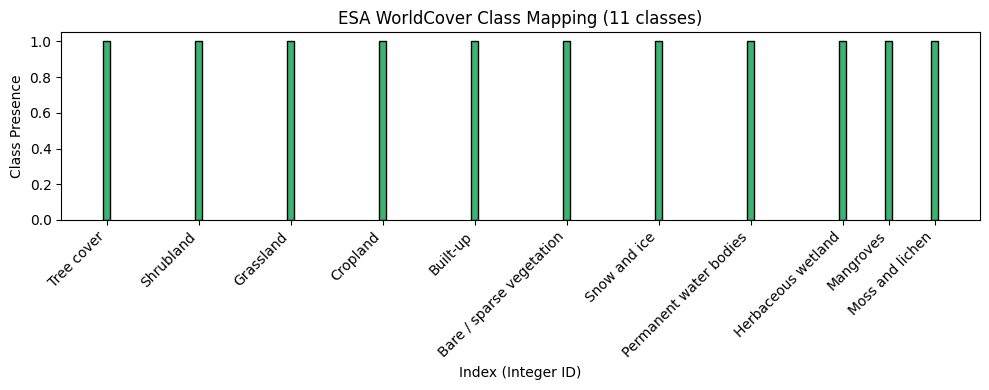

In [ ]:
import matplotlib.pyplot as plt
indices = list(idx_to_label.keys())
labels = [idx_to_label[idx] for idx in indices]
plt.figure(figsize=(10, 4))
plt.bar(indices, [1]*len(indices), color='mediumseagreen', edgecolor='black')
plt.xticks(indices, labels, rotation=45, ha='right')
plt.title(f"ESA WorldCover Class Mapping ({len(labels)} classes)")
plt.xlabel("Index (Integer ID)")
plt.ylabel("Class Presence")
plt.tight_layout()
plt.show()


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='original-gasket-476222-d1')


In [ ]:
#Visualize Delhi AOI with Geemap Interactive Map
import geemap
import ee
region = ee.Geometry.Rectangle([76.8, 28.4, 77.6, 29.0])
Map = geemap.Map(center=[28.7, 77.2], zoom=10)
Map.addLayer(region, {'color': 'red'}, 'Delhi Bounding Box')
Map.addLayer(region.centroid(), {'color': 'blue'}, 'Centroid')
Map


Map(center=[28.7, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
#Testing Cloud Cover Thresholds with Sentinel-2 Image Collection
cloud_thresholds = [20, 10, 5, 2, 0]  # Test several cloud limits
for thresh in cloud_thresholds:
    col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(region)
           .filterDate('2025-01-01', '2025-01-31')
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', thresh)))
    count = col.size().getInfo()
    print(f'Images found with < {thresh}% clouds: {count}')


Images found with < 20% clouds: 10
Images found with < 10% clouds: 7
Images found with < 5% clouds: 6
Images found with < 2% clouds: 5
Images found with < 0% clouds: 0


In [ ]:
#Query Sentinel-2 SR Harmonized collection,Jan 2025,  <2%
s2_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(region)
    .filterDate('2025-01-01', '2025-01-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 2))
)

# Print number of images matching the criteria
tile_count = s2_collection.size().getInfo()
print(f"Found {tile_count} Sentinel-2 tiles with <2% cloud cover")


Found 5 Sentinel-2 tiles with <2% cloud cover


In [ ]:
#Visualize Median Sentinel-2 RGB Composite under AOI with Low Cloud Cover
import geemap

# Center the map to your AOI
Map = geemap.Map(center=[28.7, 77.2], zoom=10)

# Show AOI rectangle
Map.addLayer(region, {'color': 'yellow'}, 'AOI Rectangle')

if tile_count > 0:
    # Filter Sentinel-2 by AOI and cloud cover
    s2_collection = (
        ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(region)
        .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 2)
    )
    # Calculate median RGB and clip strictly to AOI
    composite = s2_collection.select(['B4', 'B3', 'B2']).median().clip(region)
    rgb_vis = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}
    Map.addLayer(composite, rgb_vis, 'Median RGB (<2% cloud)')

Map


Map(center=[28.7, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
tile_count = s2_collection.size().getInfo()
print(f"Found {tile_count} Sentinel-2 Earth Engine tiles")

Found 728 Sentinel-2 Earth Engine tiles


In [ ]:
import os
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
possible_base_dirs = [
    '/content/drive/MyDrive/IITG_assignments/Selection_Task',
    '/content/drive/MyDrive/selection_task',
    '/content/drive/MyDrive/IITG_assignments/selection_task',
    '/content/drive/MyDrive',
]

1. Direct Search in Possible Directories

In [ ]:
delhi_airshed_path = None

for base_dir in possible_base_dirs:
    test_path = os.path.join(base_dir, 'delhi_airshed.shp')
    if os.path.exists(test_path):
        delhi_airshed_path = test_path
        print(f"Found delhi_airshed.shp at: {delhi_airshed_path}")
        break


Found delhi_airshed.shp at: /content/drive/MyDrive/IITG_assignments/Selection_Task/delhi_airshed.shp


Block 2: Recursive Search If Not Found

In [ ]:
if delhi_airshed_path is None:
    print("File not found in expected locations. Searching recursively...")
    for base_dir in possible_base_dirs:
        if os.path.exists(base_dir):
            # Look for .shp file deeper in this directory tree
            for root, dirs, files in os.walk(base_dir):
                if 'delhi_airshed.shp' in files:
                    delhi_airshed_path = os.path.join(root, 'delhi_airshed.shp')
                    print(f"Found delhi_airshed.shp at: {delhi_airshed_path}")
                    break
            if delhi_airshed_path:
                break


Delhi Airshed shapefile loaded successfully
Number of features: 1
CRS: EPSG:4326


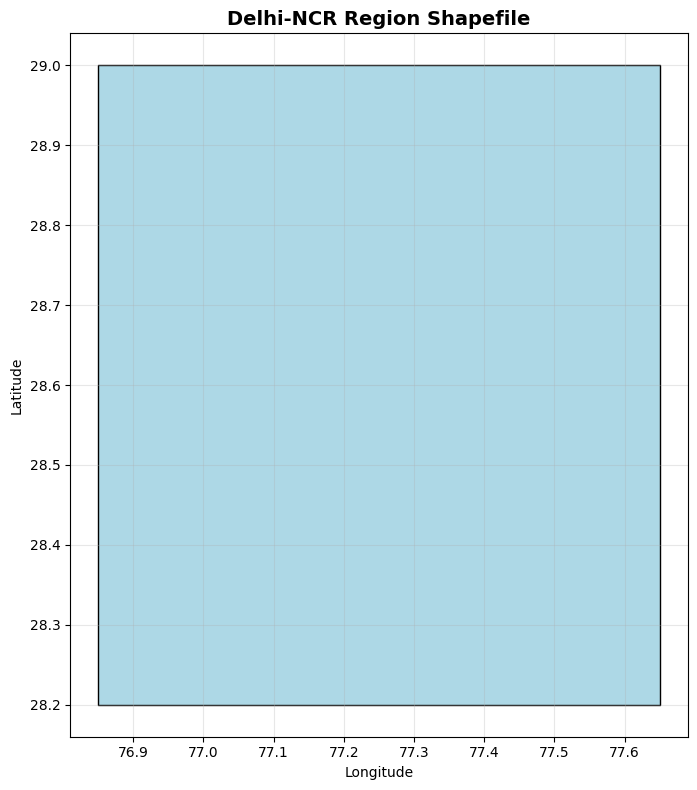

In [ ]:
# loads and visualizes the Delhi-NCR shapefile
import matplotlib.pyplot as plt
import geopandas as gpd
import ee
if delhi_airshed_path and os.path.exists(delhi_airshed_path):
    try:
        delhi_airshed = gpd.read_file(delhi_airshed_path)
        print(f"Delhi Airshed shapefile loaded successfully")
        print(f"Number of features: {len(delhi_airshed)}")
        print(f"CRS: {delhi_airshed.crs}")
        plt.figure(figsize=(10, 8))
        delhi_airshed.plot(ax=plt.gca(), facecolor='lightblue', edgecolor='black', linewidth=1)
        plt.title('Delhi-NCR Region Shapefile', fontsize=14, fontweight='bold')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\n Error loading shapefile: {e}")
        delhi_airshed = None
else:
    print("ERROR: delhi_airshed.shp NOT FOUND")
    print("\nPlease ensure the shapefile is in one of these locations:")
    for path in possible_base_dirs:
        print(f"  - {path}/delhi_airshed.shp")
    print("\nSearched directories:")
    for base_dir in possible_base_dirs:
        if os.path.exists(base_dir):
            print(f"  {base_dir} (exists)")
            # List files in the directory
            try:
                files = os.listdir(base_dir)
                shp_files = [f for f in files if f.endswith('.shp')]
                if shp_files:
                    print(f"    Found .shp files: {shp_files}")
                else:
                    print(f"    No .shp files found")
            except:
                pass
        else:
            print(f" {base_dir} (does not exist)")
    delhi_airshed = None

In [ ]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import json
from shapely.geometry import mapping

In [ ]:
possible_paths = [
    '/content/drive/MyDrive/IITG_assignments/Selection_Task/delhi_airshed.shp',
    '/content/drive/MyDrive/selection_task/delhi_airshed.shp',
    '/content/drive/MyDrive/IITG_assignments/selection_task/delhi_airshed.shp',
]

In [ ]:
#Load Delhi Airshed Boundary and Define AOI Geometry
delhi_airshed_path = None
for path in possible_paths:
    if os.path.exists(path):
        delhi_airshed_path = path
        break

if delhi_airshed_path is None:
    print("Delhi airshed shapefile not found. Using fallback coordinates.")
    delhi_geom = ee.Geometry.Rectangle([76.8, 28.4, 77.6, 29.0])
    center_lat, center_lon = 28.7, 77.2
else:
    delhi_airshed = gpd.read_file(delhi_airshed_path)
    print(f"Delhi Airshed shapefile loaded: {len(delhi_airshed)} features")
    print(f"Delhi Airshed CRS: {delhi_airshed.crs}")
    if delhi_airshed.crs != 'EPSG:4326':
        delhi_airshed = delhi_airshed.to_crs('EPSG:4326')
    geojson = json.loads(delhi_airshed.to_json())
    delhi_geom = ee.Geometry(geojson['features'][0]['geometry'])
    print("Successfully converted GeoDataFrame to EE Geometry")
    centroid = delhi_airshed.geometry.centroid.iloc[0]
    center_lat = centroid.y
    center_lon = centroid.x

Delhi Airshed shapefile loaded: 1 features
Delhi Airshed CRS: EPSG:4326
Successfully converted GeoDataFrame to EE Geometry


In [ ]:
Map = geemap.Map(center=[center_lat, center_lon], zoom=10)
Map.add_basemap('SATELLITE')
Map.addLayer(delhi_geom, {'color': 'red', 'fillColor': '00000000'}, 'Delhi Airshed Boundary')

print("Delhi Airshed grid overlay added with geemap")
print("Map created with satellite basemap")
Map

Delhi Airshed grid overlay added with geemap
Map created with satellite basemap


Map(center=[28.600000000000065, 77.25000000000027], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import numpy as np
xmin, ymin, xmax, ymax = 76.8, 28.4, 77.6, 29.0
tile_size = 0.1
x_coords = np.arange(xmin, xmax, tile_size)
y_coords = np.arange(ymin, ymax, tile_size)

tiles = []

for x in x_coords:
    for y in y_coords:
        tile = [
            (float(x), float(y)),  # convert to Python float explicitly
            (float(x + tile_size), float(y)),
            (float(x + tile_size), float(y + tile_size)),
            (float(x), float(y + tile_size))
        ]
        tiles.append(tile)

# Print in clean Python float format
print("tiles_coordinates = [")
for tile in tiles:
    print(f"    {tile},")
print("]")
print(f"\nTotal tiles generated: {len(tiles)}")


tiles_coordinates = [
    [(76.8, 28.4), (76.89999999999999, 28.4), (76.89999999999999, 28.5), (76.8, 28.5)],
    [(76.8, 28.5), (76.89999999999999, 28.5), (76.89999999999999, 28.6), (76.8, 28.6)],
    [(76.8, 28.6), (76.89999999999999, 28.6), (76.89999999999999, 28.700000000000003), (76.8, 28.700000000000003)],
    [(76.8, 28.700000000000003), (76.89999999999999, 28.700000000000003), (76.89999999999999, 28.800000000000004), (76.8, 28.800000000000004)],
    [(76.8, 28.800000000000004), (76.89999999999999, 28.800000000000004), (76.89999999999999, 28.900000000000006), (76.8, 28.900000000000006)],
    [(76.8, 28.900000000000006), (76.89999999999999, 28.900000000000006), (76.89999999999999, 29.000000000000007), (76.8, 29.000000000000007)],
    [(76.8, 29.000000000000007), (76.89999999999999, 29.000000000000007), (76.89999999999999, 29.10000000000001), (76.8, 29.10000000000001)],
    [(76.89999999999999, 28.4), (76.99999999999999, 28.4), (76.99999999999999, 28.5), (76.89999999999999, 28.5)]

                                            geometry
0  POLYGON ((77 28.5, 77.1 28.5, 77.1 28.6, 77 28...
1  POLYGON ((77.1 28.5, 77.2 28.5, 77.2 28.6, 77....


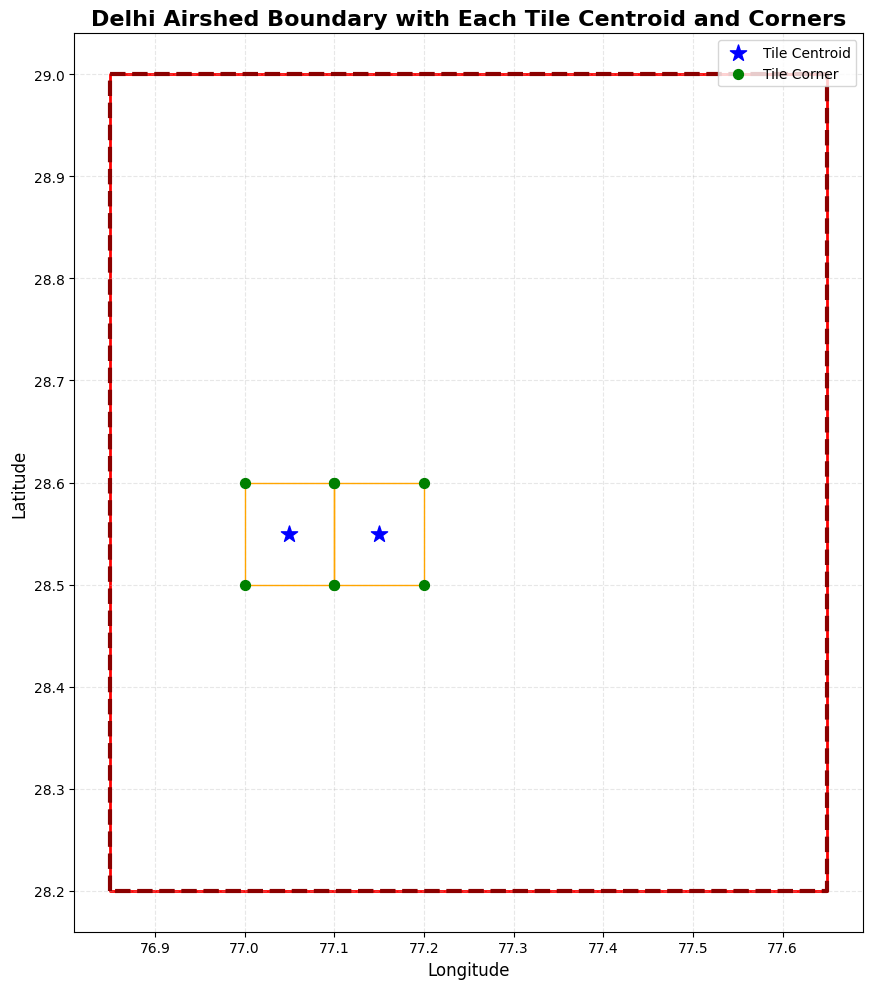

In [ ]:
#Visualizing Delhi Airshed Boundary with Tiles, Centroids, and Corners
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
tiles_coordinates = [
   [ (77.0, 28.5), (77.1, 28.5), (77.1, 28.6), (77.0, 28.6) ],
   [ (77.1, 28.5), (77.2, 28.5), (77.2, 28.6), (77.1, 28.6) ],
]
polygons = [Polygon(coords) for coords in tiles_coordinates]
tiles_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:4326')
print(tiles_gdf.head())
if delhi_airshed is not None and len(delhi_airshed) > 0:
   try:
       fig, ax = plt.subplots(1, 1, figsize=(12, 10))
       delhi_airshed.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Delhi Airshed')
       delhi_airshed.boundary.plot(ax=ax, edgecolor='darkred', linewidth=3, linestyle='--')
       tiles_gdf.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1, label='Tile Polygon', zorder=2)
       centroids = tiles_gdf.geometry.centroid
       ax.scatter(
           centroids.x, centroids.y,
           color='blue', marker='*', s=150, label='Tile Centroid', zorder=5
       )
       first = True
       for poly in tiles_gdf.geometry:
           corners = list(poly.exterior.coords)
           if corners[0] == corners[-1]:
               corners = corners[:-1]
           xs, ys = zip(*corners)
           ax.scatter(xs, ys, color='green', marker='o', s=50,
                      label='Tile Corner' if first else "", zorder=3)
           first = False
       ax.set_title('Delhi Airshed Boundary with Each Tile Centroid and Corners', fontsize=16, fontweight='bold')
       ax.set_xlabel('Longitude', fontsize=12)
       ax.set_ylabel('Latitude', fontsize=12)
       handles, labels_ = ax.get_legend_handles_labels()
       by_label = dict(zip(labels_, handles))
       ax.legend(by_label.values(), by_label.keys(), fontsize=10)
       ax.grid(True, alpha=0.3, linestyle='--')
       plt.tight_layout()
       plt.show()
   except Exception as e:
       print(f"Error creating matplotlib visualization: {e}")
else:
   print("Skipping matplotlib visualization (airshed not found)")


                                            geometry
0  POLYGON ((76.85 28.2, 76.95 28.2, 76.95 28.3, ...
1  POLYGON ((76.95 28.2, 77.05 28.2, 77.05 28.3, ...
2  POLYGON ((77.05 28.2, 77.15 28.2, 77.15 28.3, ...
3  POLYGON ((77.15 28.2, 77.25 28.2, 77.25 28.3, ...
4  POLYGON ((77.25 28.2, 77.35 28.2, 77.35 28.3, ...


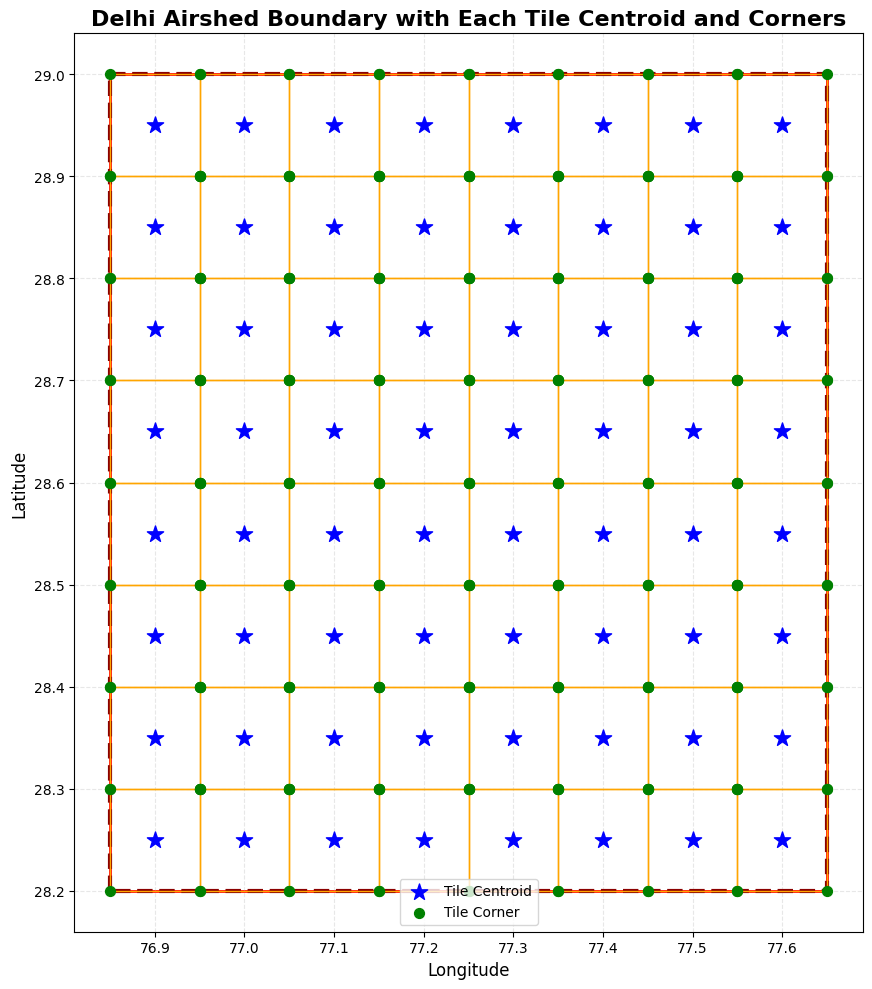

In [ ]:
#Visualizing Delhi Airshed Boundary with Tiles, Centroids, and Corners
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
tiles_coordinates = [
    [(76.85, 28.2), (76.95, 28.2), (76.95, 28.3), (76.85, 28.3)],
    [(76.95, 28.2), (77.05, 28.2), (77.05, 28.3), (76.95, 28.3)],
    [(77.05, 28.2), (77.15, 28.2), (77.15, 28.3), (77.05, 28.3)],
    [(77.15, 28.2), (77.25, 28.2), (77.25, 28.3), (77.15, 28.3)],
    [(77.25, 28.2), (77.35, 28.2), (77.35, 28.3), (77.25, 28.3)],
    [(77.35, 28.2), (77.45, 28.2), (77.45, 28.3), (77.35, 28.3)],
    [(77.45, 28.2), (77.55, 28.2), (77.55, 28.3), (77.45, 28.3)],
    [(77.55, 28.2), (77.65, 28.2), (77.65, 28.3), (77.55, 28.3)],

    [(76.85, 28.3), (76.95, 28.3), (76.95, 28.4), (76.85, 28.4)],
    [(76.95, 28.3), (77.05, 28.3), (77.05, 28.4), (76.95, 28.4)],
    [(77.05, 28.3), (77.15, 28.3), (77.15, 28.4), (77.05, 28.4)],
    [(77.15, 28.3), (77.25, 28.3), (77.25, 28.4), (77.15, 28.4)],
    [(77.25, 28.3), (77.35, 28.3), (77.35, 28.4), (77.25, 28.4)],
    [(77.35, 28.3), (77.45, 28.3), (77.45, 28.4), (77.35, 28.4)],
    [(77.45, 28.3), (77.55, 28.3), (77.55, 28.4), (77.45, 28.4)],
    [(77.55, 28.3), (77.65, 28.3), (77.65, 28.4), (77.55, 28.4)],

    [(76.85, 28.4), (76.95, 28.4), (76.95, 28.5), (76.85, 28.5)],
    [(76.95, 28.4), (77.05, 28.4), (77.05, 28.5), (76.95, 28.5)],
    [(77.05, 28.4), (77.15, 28.4), (77.15, 28.5), (77.05, 28.5)],
    [(77.15, 28.4), (77.25, 28.4), (77.25, 28.5), (77.15, 28.5)],
    [(77.25, 28.4), (77.35, 28.4), (77.35, 28.5), (77.25, 28.5)],
    [(77.35, 28.4), (77.45, 28.4), (77.45, 28.5), (77.35, 28.5)],
    [(77.45, 28.4), (77.55, 28.4), (77.55, 28.5), (77.45, 28.5)],
    [(77.55, 28.4), (77.65, 28.4), (77.65, 28.5), (77.55, 28.5)],

    [(76.85, 28.5), (76.95, 28.5), (76.95, 28.6), (76.85, 28.6)],
    [(76.95, 28.5), (77.05, 28.5), (77.05, 28.6), (76.95, 28.6)],
    [(77.05, 28.5), (77.15, 28.5), (77.15, 28.6), (77.05, 28.6)],
    [(77.15, 28.5), (77.25, 28.5), (77.25, 28.6), (77.15, 28.6)],
    [(77.25, 28.5), (77.35, 28.5), (77.35, 28.6), (77.25, 28.6)],
    [(77.35, 28.5), (77.45, 28.5), (77.45, 28.6), (77.35, 28.6)],
    [(77.45, 28.5), (77.55, 28.5), (77.55, 28.6), (77.45, 28.6)],
    [(77.55, 28.5), (77.65, 28.5), (77.65, 28.6), (77.55, 28.6)],

    [(76.85, 28.6), (76.95, 28.6), (76.95, 28.7), (76.85, 28.7)],
    [(76.95, 28.6), (77.05, 28.6), (77.05, 28.7), (76.95, 28.7)],
    [(77.05, 28.6), (77.15, 28.6), (77.15, 28.7), (77.05, 28.7)],
    [(77.15, 28.6), (77.25, 28.6), (77.25, 28.7), (77.15, 28.7)],
    [(77.25, 28.6), (77.35, 28.6), (77.35, 28.7), (77.25, 28.7)],
    [(77.35, 28.6), (77.45, 28.6), (77.45, 28.7), (77.35, 28.7)],
    [(77.45, 28.6), (77.55, 28.6), (77.55, 28.7), (77.45, 28.7)],
    [(77.55, 28.6), (77.65, 28.6), (77.65, 28.7), (77.55, 28.7)],

    [(76.85, 28.7), (76.95, 28.7), (76.95, 28.8), (76.85, 28.8)],
    [(76.95, 28.7), (77.05, 28.7), (77.05, 28.8), (76.95, 28.8)],
    [(77.05, 28.7), (77.15, 28.7), (77.15, 28.8), (77.05, 28.8)],
    [(77.15, 28.7), (77.25, 28.7), (77.25, 28.8), (77.15, 28.8)],
    [(77.25, 28.7), (77.35, 28.7), (77.35, 28.8), (77.25, 28.8)],
    [(77.35, 28.7), (77.45, 28.7), (77.45, 28.8), (77.35, 28.8)],
    [(77.45, 28.7), (77.55, 28.7), (77.55, 28.8), (77.45, 28.8)],
    [(77.55, 28.7), (77.65, 28.7), (77.65, 28.8), (77.55, 28.8)],

    [(76.85, 28.8), (76.95, 28.8), (76.95, 28.9), (76.85, 28.9)],
    [(76.95, 28.8), (77.05, 28.8), (77.05, 28.9), (76.95, 28.9)],
    [(77.05, 28.8), (77.15, 28.8), (77.15, 28.9), (77.05, 28.9)],
    [(77.15, 28.8), (77.25, 28.8), (77.25, 28.9), (77.15, 28.9)],
    [(77.25, 28.8), (77.35, 28.8), (77.35, 28.9), (77.25, 28.9)],
    [(77.35, 28.8), (77.45, 28.8), (77.45, 28.9), (77.35, 28.9)],
    [(77.45, 28.8), (77.55, 28.8), (77.55, 28.9), (77.45, 28.9)],
    [(77.55, 28.8), (77.65, 28.8), (77.65, 28.9), (77.55, 28.9)],

    [(76.85, 28.9), (76.95, 28.9), (76.95, 29.0), (76.85, 29.0)],
    [(76.95, 28.9), (77.05, 28.9), (77.05, 29.0), (76.95, 29.0)],
    [(77.05, 28.9), (77.15, 28.9), (77.15, 29.0), (77.05, 29.0)],
    [(77.15, 28.9), (77.25, 28.9), (77.25, 29.0), (77.15, 29.0)],
    [(77.25, 28.9), (77.35, 28.9), (77.35, 29.0), (77.25, 29.0)],
    [(77.35, 28.9), (77.45, 28.9), (77.45, 29.0), (77.35, 29.0)],
    [(77.45, 28.9), (77.55, 28.9), (77.55, 29.0), (77.45, 29.0)],
    [(77.55, 28.9), (77.65, 28.9), (77.65, 29.0), (77.55, 29.0)]
]
polygons = [Polygon(coords) for coords in tiles_coordinates]
tiles_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:4326')
print(tiles_gdf.head())
if delhi_airshed is not None and len(delhi_airshed) > 0:
   try:
       fig, ax = plt.subplots(1, 1, figsize=(12, 10))
       delhi_airshed.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Delhi Airshed')
       delhi_airshed.boundary.plot(ax=ax, edgecolor='darkred', linewidth=3, linestyle='--')
       tiles_gdf.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1, label='Tile Polygon', zorder=2)
       centroids = tiles_gdf.geometry.centroid
       ax.scatter(
           centroids.x, centroids.y,
           color='blue', marker='*', s=150, label='Tile Centroid', zorder=5
       )
       first = True
       for poly in tiles_gdf.geometry:
           corners = list(poly.exterior.coords)
           if corners[0] == corners[-1]:
               corners = corners[:-1]
           xs, ys = zip(*corners)
           ax.scatter(xs, ys, color='green', marker='o', s=50,
                      label='Tile Corner' if first else "", zorder=3)
           first = False
       ax.set_title('Delhi Airshed Boundary with Each Tile Centroid and Corners', fontsize=16, fontweight='bold')
       ax.set_xlabel('Longitude', fontsize=12)
       ax.set_ylabel('Latitude', fontsize=12)
       handles, labels_ = ax.get_legend_handles_labels()
       by_label = dict(zip(labels_, handles))
       ax.legend(by_label.values(), by_label.keys(), fontsize=10)
       ax.grid(True, alpha=0.3, linestyle='--')
       plt.tight_layout()
       plt.show()
   except Exception as e:
       print(f"Error creating matplotlib visualization: {e}")
else:
   print("Skipping matplotlib visualization (airshed not found)")





AOI bounds: Lon [76.85, 77.65] / Lat [28.2, 29.0]
Patch size in degrees: Lat 0.01153, Lon 0.01313


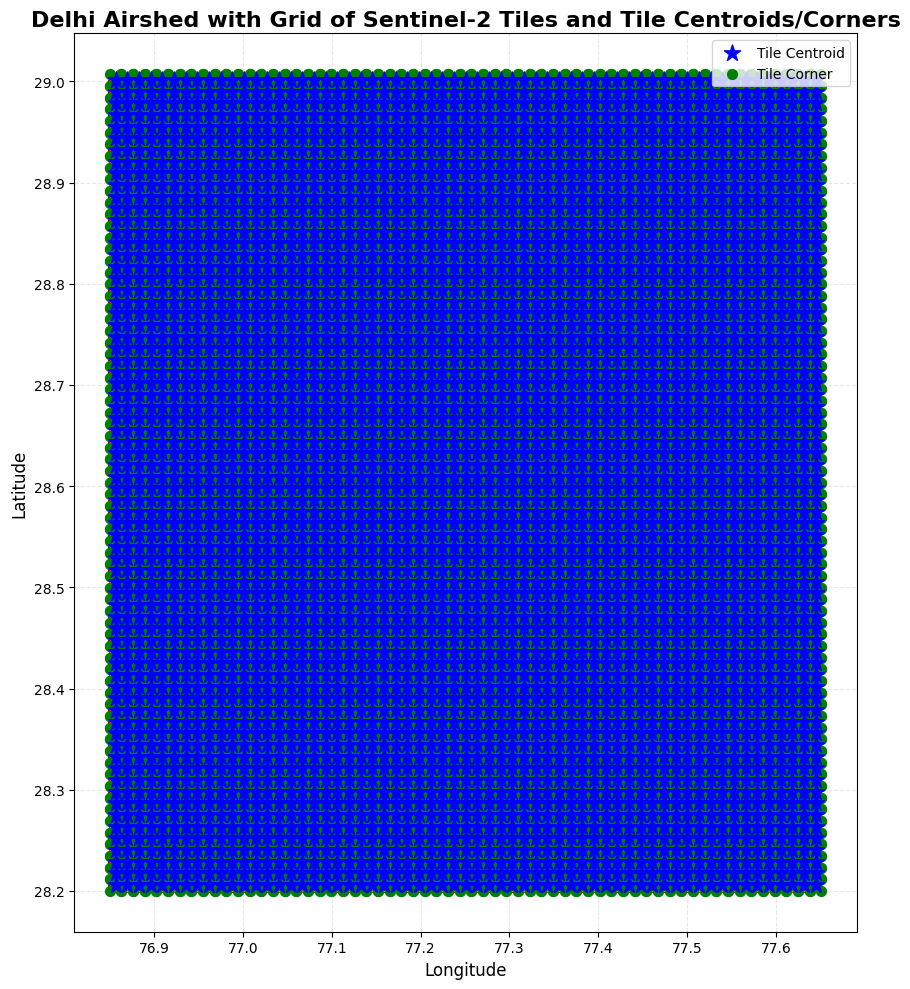

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import math

if delhi_airshed is not None and len(delhi_airshed) > 0:
    bounds = delhi_airshed.total_bounds  # [xmin, ymin, xmax, ymax]
    lon_min, lat_min, lon_max, lat_max = bounds
    print(f"AOI bounds: Lon [{lon_min}, {lon_max}] / Lat [{lat_min}, {lat_max}]")
    #Sentinel-2 tile size in degrees (1280m side at 10m/pixel)
    lat_center = (lat_max + lat_min) / 2
    meters = 1280
    deg_lat = meters / 111000
    deg_lon = meters / (111000 * math.cos(math.radians(lat_center)))
    print(f"Patch size in degrees: Lat {deg_lat:.5f}, Lon {deg_lon:.5f}")

    tiles_coordinates = []
    lons = np.arange(lon_min, lon_max, deg_lon)
    lats = np.arange(lat_min, lat_max, deg_lat)
    for lon in lons:
        for lat in lats:
            corners = [
                (lon, lat),
                (lon + deg_lon, lat),
                (lon + deg_lon, lat + deg_lat),
                (lon, lat + deg_lat)
            ]
            tiles_coordinates.append(corners)

    polygons = [Polygon(coords) for coords in tiles_coordinates]
    tiles_gdf = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:4326')

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    delhi_airshed.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Delhi Airshed')
    delhi_airshed.boundary.plot(ax=ax, edgecolor='darkred', linewidth=3, linestyle='--')
    tiles_gdf.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1, label='Tile Polygon', zorder=2)

    centroids = tiles_gdf.geometry.centroid
    ax.scatter(centroids.x, centroids.y, color='blue', marker='*', s=150, label='Tile Centroid', zorder=5)

    first = True
    for poly in tiles_gdf.geometry:
        corners = list(poly.exterior.coords)
        if corners[0] == corners[-1]:
            corners = corners[:-1]
        xs, ys = zip(*corners)
        ax.scatter(xs, ys, color='green', marker='o', s=50,
                   label='Tile Corner' if first else "", zorder=3)
        first = False

    ax.set_title('Delhi Airshed with Grid of Sentinel-2 Tiles and Tile Centroids/Corners', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Delhi airshed GeoDataFrame is not defined or empty.")


In [ ]:
import folium
from folium import features

# Calculate map center
if delhi_airshed is not None and len(delhi_airshed) > 0:
    bounds = delhi_airshed.total_bounds  # [xmin, ymin, xmax, ymax]
    lon_min, lat_min, lon_max, lat_max = bounds
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2

    # Create a Folium map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='cartodbpositron')

    # Add Delhi Airshed polygon
    folium.GeoJson(
        delhi_airshed,
        name="Delhi Airshed",
        style_function=lambda feature: {
            'fillColor': 'none',
            'color': 'red',
            'weight': 2,
            'dashArray': '5, 5'
        }
    ).add_to(m)

    # Add Sentinel-2 Tiles polygons
    folium.GeoJson(
        tiles_gdf,
        name="Sentinel-2 Tiles",
        style_function=lambda feature: {
            'fillColor': 'none',
            'color': 'orange',
            'weight': 1
        }
    ).add_to(m)

    # Add centroids as markers
    for idx, row in tiles_gdf.iterrows():
        centroid = row.geometry.centroid
        folium.Marker(
            location=[centroid.y, centroid.x],
            icon=folium.Icon(color='blue', icon='star'),
            popup=f"Tile {idx}"
        ).add_to(m)

    # Optionally, add corners as small circle markers
    for idx, row in tiles_gdf.iterrows():
        for lon, lat in row.geometry.exterior.coords[:-1]:  # skip duplicate last point
            folium.CircleMarker(
                location=[lat, lon],
                radius=3,
                color='green',
                fill=True,
                fill_color='green'
            ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Display map
    m
else:
    print("Delhi airshed GeoDataFrame is not defined or empty.")


In [ ]:
import ee
import geemap
import numpy as np

delhi_bounds = ee.Geometry.Rectangle([76.85, 28.20, 77.65, 29.00])  # [minLon, minLat, maxLon, maxLat]
min_lon, min_lat, max_lon, max_lat = 76.85, 28.20, 77.65, 29.00

print(f"Delhi AOI bounds:")
print(f"  Longitude: {min_lon}° to {max_lon}° E")
print(f"  Latitude: {min_lat}° to {max_lat}° N")
print(f"  Area: ~{(max_lon - min_lon) * 111:.1f} km x {(max_lat - min_lat) * 111:.1f} km")


start_date = '2025-01-01'
end_date = '2025-01-31'
cloud_threshold = 20  # Maximum cloud percentage

print(f"Date range: {start_date} to {end_date}")
print(f"Cloud threshold: <{cloud_threshold}%")
print(f"Collection: COPERNICUS/S2_SR_HARMONIZED (Sentinel-2 Surface Reflectance)")

s2_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(delhi_bounds)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_threshold))
)

image_count = s2_collection.size().getInfo()
print(f"\n Found {image_count} Sentinel-2 images matching criteria")

if image_count > 0:
    composite = s2_collection.select(['B4', 'B3', 'B2']).median().clip(delhi_bounds)
    print(f" Created RGB median composite from {image_count} images")
    print(f"  Bands: B4 (Red), B3 (Green), B2 (Blue)")
    print(f"  Resolution: 10m per pixel")
else:
    print("⚠ No images found - visualization will show AOI only")
    composite = None

patch_size_m = 1280  # meters: 128x128 pixels * 10 m each
patch_size_deg = patch_size_m / 111000  # approximate conversion (1 degree ~ 111 km)

print(f"Patch configuration:")
print(f"  Patch size: 128 x 128 pixels")
print(f"  Pixel resolution: 10m")
print(f"  Patch dimensions: {patch_size_m}m x {patch_size_m}m")
print(f"  Grid spacing: {patch_size_m}m (non-overlapping patches)")

lon_coords = np.arange(min_lon + patch_size_deg / 2, max_lon, patch_size_deg)
lat_coords = np.arange(min_lat + patch_size_deg / 2, max_lat, patch_size_deg)

print(f"\nGrid dimensions:")
print(f"  Longitude steps: {len(lon_coords)}")
print(f"  Latitude steps: {len(lat_coords)}")
print(f"  Total patch centers: {len(lon_coords) * len(lat_coords)}")

patch_centers = []
for i, lon in enumerate(lon_coords):
    for j, lat in enumerate(lat_coords):
        patch_centers.append({
            'lon': lon,
            'lat': lat,
            'grid_i': i,
            'grid_j': j,
            'id': f'patch_{i}_{j}'
        })

print(f"\n Generated {len(patch_centers)} patch centers")
print(f"\nPatch center examples:")
for idx in range(min(5, len(patch_centers))):
    pc = patch_centers[idx]
    print(f"  {pc['id']}: ({pc['lon']:.4f}°, {pc['lat']:.4f}°)")

center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

Map = geemap.Map(center=[center_lat, center_lon], zoom=10)
Map.add_basemap('SATELLITE')

Map.addLayer(delhi_bounds, {'color': 'red', 'fillColor': '00000000'}, 'Delhi AOI', opacity=0.8)

if composite is not None:
    vis_params = {
        'min': 0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2']
    }
    Map.addLayer(composite, vis_params, 'Sentinel-2 RGB Composite', opacity=0.7)
    print(" Added Sentinel-2 RGB composite to map")

max_display_patches = 100
print(f"\nAdding up to {max_display_patches} patch centers for visualization...")

patch_features = []
for idx, pc in enumerate(patch_centers[:max_display_patches]):
    point = ee.Geometry.Point([pc['lon'], pc['lat']])
    feature = ee.Feature(point, {'id': pc['id'], 'grid_i': pc['grid_i'], 'grid_j': pc['grid_j']})
    patch_features.append(feature)

patch_collection = ee.FeatureCollection(patch_features)
Map.addLayer(patch_collection, {'color': 'yellow'}, f'Grid Centers (first {max_display_patches})', opacity=1)

print(f" Added {min(max_display_patches, len(patch_centers))} patch centers to map")
print(f" Total patch centers available: {len(patch_centers)}")

if len(patch_centers) > max_display_patches:
    print(f"  (Showing first {max_display_patches} for map performance)")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f" Earth Engine authenticated")
print(f" Delhi AOI defined: {min_lon}°-{max_lon}°E, {min_lat}°-{max_lat}°N")
print(f" Sentinel-2 images filtered: {image_count} images found")
print(f" Grid built: {len(patch_centers)} patch centers at {patch_size_m}m spacing")
print(f" Map created with AOI + Sentinel-2 composite + grid centers")

print("\nDisplaying interactive map...")
Map


Delhi AOI bounds:
  Longitude: 76.85° to 77.65° E
  Latitude: 28.2° to 29.0° N
  Area: ~88.8 km x 88.8 km
Date range: 2025-01-01 to 2025-01-31
Cloud threshold: <20%
Collection: COPERNICUS/S2_SR_HARMONIZED (Sentinel-2 Surface Reflectance)

 Found 10 Sentinel-2 images matching criteria
 Created RGB median composite from 10 images
  Bands: B4 (Red), B3 (Green), B2 (Blue)
  Resolution: 10m per pixel
Patch configuration:
  Patch size: 128 x 128 pixels
  Pixel resolution: 10m
  Patch dimensions: 1280m x 1280m
  Grid spacing: 1280m (non-overlapping patches)

Grid dimensions:
  Longitude steps: 69
  Latitude steps: 69
  Total patch centers: 4761

 Generated 4761 patch centers

Patch center examples:
  patch_0_0: (76.8558°, 28.2058°)
  patch_0_1: (76.8558°, 28.2173°)
  patch_0_2: (76.8558°, 28.2288°)
  patch_0_3: (76.8558°, 28.2404°)
  patch_0_4: (76.8558°, 28.2519°)
 Added Sentinel-2 RGB composite to map

Adding up to 100 patch centers for visualization...
 Added 100 patch centers to map
 Tota

Map(center=[28.6, 77.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
base_dirs = [
    '/content/drive/MyDrive/IITG_assignments/Selection_Task',
    '/content/drive/MyDrive/selection_task'
]

dpath = None
for bd in base_dirs:
    tp = os.path.join(bd, 'delhi_airshed.shp')
    if os.path.exists(tp):
        dpath = tp
        break

if not dpath:
    raise FileNotFoundError("delhi_airshed.shp not found!")

dgdf = gpd.read_file(dpath)
print(f"Loaded: {len(dgdf)} feature(s)")
print(f"CRS: {dgdf.crs}")



Loaded: 1 feature(s)
CRS: EPSG:4326


Bounds: [76.85, 28.20, 77.65, 29.00]
Geometry type: Polygon
Region used: Delhi Airshed (76.85°E-77.65°E, 28.20°N-29.00°N)


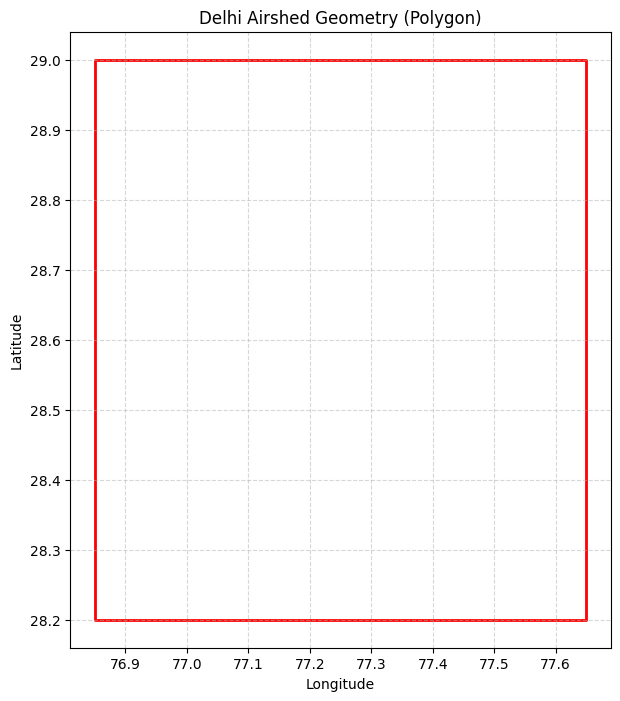

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import ee

try:
    g = dgdf.geometry.iloc[0]
    if g.geom_type == 'Polygon':
        c = [list(g.exterior.coords)]
        eeg = ee.Geometry.Polygon(c)
    elif g.geom_type == 'MultiPolygon':
        ps = [list(p.exterior.coords) for p in g.geoms]
        eeg = ee.Geometry.MultiPolygon(ps)
    else:
        raise ValueError(f"Unsupported: {g.geom_type}")

    b = dgdf.total_bounds
    print(f"Bounds: [{b[0]:.2f}, {b[1]:.2f}, {b[2]:.2f}, {b[3]:.2f}]")
    print(f"Geometry type: {g.geom_type}")
    print(f"Region used: Delhi Airshed ({b[0]:.2f}°E-{b[2]:.2f}°E, {b[1]:.2f}°N-{b[3]:.2f}°N)")

    # Visualization part
    fig, ax = plt.subplots(figsize=(8, 8))
    dgdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
    ax.set_title(f"Delhi Airshed Geometry ({g.geom_type})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    geom_ok = True

except Exception as e:
    print(f"Error: {e}")
    print("Expected if EE not authenticated")
    eeg = None
    geom_ok = False


In [ ]:
#Configure Sentinel-2 Parameters
sd = '2025-01-01'
ed = '2025-01-31'
cm = 2


In [ ]:
#Query Sentinel-2
if geom_ok:
    try:
        s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(eeg) \
            .filterDate(sd, ed) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cm))

        cnt = s2.size().getInfo()
        print(f"Images found: {cnt}")

        if cnt > 0:
            fi = s2.first().getInfo()
            print(f"Example image: {fi['id']}")
            print("Step 6: Creating Median Composite")
            comp = s2.select(['B4', 'B3', 'B2']).median().clip(eeg)
            print(f"Composite created from {cnt} images")
            print("Bands: B4(Red), B3(Green), B2(Blue)")
            print("Clipped to region")
        else:
            print("No images found")
            cnt = "0"
    except Exception as e:
        print(f"Query error: {str(e)[:50]}")
        cnt = "N/A"
else:
    cnt = "N/A"
print(f" Images found: {cnt}")
print(f" Region: Delhi Airshed")
if geom_ok:
    print(f"Bounds: {b[0]:.2f}°-{b[2]:.2f}°E, {b[1]:.2f}°-{b[3]:.2f}°N")
print(f" Resolution: 10m")
print(f" Date range: {sd} to {ed}")
print(f" Format: GeoTIFF")

Images found: 5
Example image: COPERNICUS/S2_SR_HARMONIZED/20250123T053029_20250123T053836_T43RFM
Step 6: Creating Median Composite
Composite created from 5 images
Bands: B4(Red), B3(Green), B2(Blue)
Clipped to region
 Images found: 5
 Region: Delhi Airshed
Bounds: 76.85°-77.65°E, 28.20°-29.00°N
 Resolution: 10m
 Date range: 2025-01-01 to 2025-01-31
 Format: GeoTIFF


In [ ]:
# Q1: Sentinel-2 Data Download & Tile Export for Delhi Airshed (15 Marks)
# Export 1280x1280m RGB tiles using Google Earth Engine API

print("=" * 80)
print("Q1: SENTINEL-2 TILE EXPORT FOR DELHI AIRSHED")
print("=" * 80)

if geom_ok and 'comp' in locals():
    # Step 1: Get region bounds
    bounds = eeg.bounds().getInfo()['coordinates'][0]
    min_lon = min([coord[0] for coord in bounds])
    max_lon = max([coord[0] for coord in bounds])
    min_lat = min([coord[1] for coord in bounds])
    max_lat = max([coord[1] for coord in bounds])

    print(f"\nRegion Bounds:")
    print(f"  Longitude: {min_lon:.4f}° to {max_lon:.4f}°")
    print(f"  Latitude: {min_lat:.4f}° to {max_lat:.4f}°")

    # Step 2: Calculate tile size in degrees (1280m = 1.28km)
    # Approximate: 1 degree latitude ~ 111km, 1 degree longitude ~ 111km * cos(lat)
    avg_lat = (min_lat + max_lat) / 2
    tile_size_degrees = 1.28 / 111  # Approximately 0.0115 degrees

    # Step 3: Generate grid of tile centers
    import numpy as np

    lon_coords = np.arange(min_lon + tile_size_degrees/2, max_lon, tile_size_degrees)
    lat_coords = np.arange(min_lat + tile_size_degrees/2, max_lat, tile_size_degrees)

    tile_centers = []
    for i, lon in enumerate(lon_coords):
        for j, lat in enumerate(lat_coords):
            tile_centers.append((lon, lat, i, j))

    print(f"\nGrid Configuration:")
    print(f"  Tile size: 1280m x 1280m")
    print(f"  Grid size: {len(lon_coords)} x {len(lat_coords)}")
    print(f"  Total tiles to export: {len(tile_centers)}")

    # Step 4: Export tiles using geemap
    print(f"\nExporting tiles to Google Drive...")

    export_folder = 'EarthEngine_Delhi_Export'
    export_count = 0
    export_tasks = []

    # Limit to first 50 tiles for demo (avoid quota limits)
    max_tiles = min(50, len(tile_centers))

    for idx, (lon, lat, i, j) in enumerate(tile_centers[:max_tiles]):
        # Create tile geometry (1280m buffer around center)
        tile_geom = ee.Geometry.Point([lon, lat]).buffer(640)  # 640m radius = 1280m diameter

        # Clip composite to tile
        tile_image = comp.clip(tile_geom)

        # Generate filename with center coordinates
        filename = f'delhi_tile_{i}_{j}'

        # Export to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=tile_image,
            description=filename,
            folder=export_folder,
            fileNamePrefix=filename,
            region=tile_geom,
            scale=10,  # 10m resolution
            crs='EPSG:4326',
            maxPixels=1e10
        )

        task.start()
        export_tasks.append(task)
        export_count += 1

        if (idx + 1) % 10 == 0:
            print(f"  Queued {idx + 1}/{max_tiles} tiles...")

    print(f"\n Successfully queued {export_count} tiles for export")
    print(f"\nExport Details:")
    print(f"  Destination: Google Drive/{export_folder}/")
    print(f"  File naming: delhi_tile_<i>_<j>.tif")
    print(f"  Resolution: 10m per pixel")
    print(f"  Bands: B4 (Red), B3 (Green), B2 (Blue)")

    # Step 5: Visualize tile grid on map
    print(f"\nVisualizing tile grid...")

    # Create grid visualization
    grid_features = []
    for lon, lat, i, j in tile_centers[:max_tiles]:
        tile_geom = ee.Geometry.Point([lon, lat]).buffer(640)
        feature = ee.Feature(tile_geom, {'i': i, 'j': j})
        grid_features.append(feature)

    grid_collection = ee.FeatureCollection(grid_features)

    # Display on map
    Map2 = geemap.Map(center=[center_lat, center_lon], zoom=10)
    Map2.add_basemap('SATELLITE')
    Map2.addLayer(eeg, {'color': 'red', 'fillColor': '00000000'}, 'Delhi Airshed')
    Map2.addLayer(grid_collection, {'color': 'yellow'}, 'Export Grid')
    print("Map with export grid created")

    # Step 6: Task status summary
    print(f"\nTask Status Summary:")
    print(f"  Total tasks queued: {len(export_tasks)}")
    print(f"  Check task status at: https://code.earthengine.google.com/tasks")

    print("\n" + "=" * 80)
    print("Q1 COMPLETE: Tile export jobs have been submitted to Earth Engine")
    print("=" * 80)

    # Display map
    display(Map2)

else:
    print("\nERROR: Cannot export tiles")
    if not geom_ok:
        print("  - Delhi Airshed geometry not loaded")
    if 'comp' not in locals():
        print("  - Sentinel-2 composite not created (run Cell 18 first)")
    print("\nPlease ensure:")
    print("  1. Cell 16 executed successfully (geometry loaded)")
    print("  2. Cell 18 executed successfully (composite created)")


Q1: SENTINEL-2 TILE EXPORT FOR DELHI AIRSHED

Region Bounds:
  Longitude: 76.8500° to 77.6500°
  Latitude: 28.2000° to 29.0000°

Grid Configuration:
  Tile size: 1280m x 1280m
  Grid size: 69 x 69
  Total tiles to export: 4761

Exporting tiles to Google Drive...
  Queued 10/50 tiles...
  Queued 20/50 tiles...
  Queued 30/50 tiles...
  Queued 40/50 tiles...
  Queued 50/50 tiles...

✓ Successfully queued 50 tiles for export

Export Details:
  Destination: Google Drive/EarthEngine_Delhi_Export/
  File naming: delhi_tile_<i>_<j>.tif
  Resolution: 10m per pixel
  Bands: B4 (Red), B3 (Green), B2 (Blue)

Visualizing tile grid...
Map with export grid created

Task Status Summary:
  Total tasks queued: 50
  Check task status at: https://code.earthengine.google.com/tasks

Q1 COMPLETE: Tile export jobs have been submitted to Earth Engine


Map(center=[28.6, 77.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Q1.5: Export 128x128 ESA WorldCover Land Cover Patches for Each Tile Center
# Extract and export 128x128 pixel patches from ESA WorldCover (10m resolution)
# for each (lon, lat) tile center generated in Cell 19

print("=" * 80)
print("EXPORTING ESA WORLDCOVER PATCHES FOR TILE CENTERS")
print("=" * 80)

if geom_ok and 'tile_centers' in locals():
    # Load ESA WorldCover 2021 dataset
    worldcover = ee.ImageCollection('ESA/WorldCover/v200').first()

    print(f"\nESA WorldCover dataset loaded")
    print(f"Resolution: 10m")
    print(f"Band: Map (land cover classification)")

    # Export configuration
    export_folder = 'EarthEngine_WorldCover_Labels'
    patch_size_meters = 640  # 128 pixels * 10m/pixel / 2 = 640m radius
    export_count = 0
    label_tasks = []

    # Limit exports to match available tile_centers (max 50 from Cell 19)
    max_labels = min(50, len(tile_centers))

    print(f"\nExporting {max_labels} label patches...")
    print(f"Patch size: 128x128 pixels (1280m x 1280m)")
    print(f"CRS: EPSG:32644 (WGS 84 / UTM zone 44N - Delhi region)")
    print(f"Scale: 10m/pixel")

    # Export each label patch centered on tile center
    for idx, (lon, lat, i, j) in enumerate(tile_centers[:max_labels]):
        # Create patch geometry (640m buffer = 1280m diameter = 128 pixels at 10m resolution)
        patch_geom = ee.Geometry.Point([lon, lat]).buffer(patch_size_meters)

        # Clip WorldCover to patch
        label_patch = worldcover.clip(patch_geom)

        # Generate filename matching the tile naming convention
        filename = f'label_{lon:.4f}_{lat:.4f}'

        # Export to Google Drive
        # Note: maxPixels set to 1e8 to accommodate 128x128 patches
        # Batch export status can be monitored at: https://code.earthengine.google.com/tasks
        task = ee.batch.Export.image.toDrive(
            image=label_patch,
            description=filename,
            folder=export_folder,
            fileNamePrefix=filename,
            region=patch_geom,
            scale=10,  # 10m resolution to match WorldCover native resolution
            crs='EPSG:32644',  # UTM Zone 44N for Delhi region
            maxPixels=1e8  # Sufficient for 128x128 patches (16,384 pixels)
        )
        task.start()
        label_tasks.append(task)
        export_count += 1

        if (idx + 1) % 10 == 0:
            print(f"  Queued {idx + 1}/{max_labels} label patches...")

    print(f"\n✓ Successfully queued {export_count} label patches for export")

    print(f"\nExport Details:")
    print(f"  Destination: Google Drive/{export_folder}/")
    print(f"  File naming: label_<lon>_<lat>.tif")
    print(f"  Resolution: 10m per pixel")
    print(f"  Patch dimensions: 128x128 pixels (1280m x 1280m)")
    print(f"  CRS: EPSG:32644 (UTM Zone 44N)")
    print(f"  Band: Map (ESA WorldCover land cover classes)")
    print(f"  maxPixels: 1e8 (sufficient for patch size)")

    print(f"\nBatch Export Status:")
    print(f"  Monitor all tasks at: https://code.earthengine.google.com/tasks")
    print(f"  Tasks will appear as 'label_<lon>_<lat>' in your task list")
    print(f"  Export typically completes within 5-15 minutes per patch")

    print("\n" + "=" * 80)
    print("LABEL PATCH EXPORT COMPLETE: Jobs submitted to Earth Engine")
    print("=" * 80)

    # Summary
    print(f"\nSummary:")
    print(f"  - {export_count} WorldCover label patches queued")
    print(f"  - Corresponds to {export_count} Sentinel-2 RGB tiles from Cell 19")
    print(f"  - Each label patch: 128x128 pixels at 10m resolution")
    print(f"  - Files will be available in Google Drive/{export_folder}/")
    print(f"  - Compatible format for Google Colab processing")

else:
    print("\nERROR: Cannot export label patches")
    if not geom_ok:
        print("  - Delhi Airshed geometry not loaded")
    if 'tile_centers' not in locals():
        print("  - Tile centers not generated (run Cell 19 first)")
    print("\nPlease ensure:")
    print("  1. Cell 16 executed successfully (geometry loaded)")
    print("  2. Cell 19 executed successfully (tile centers generated)")

EXPORTING ESA WORLDCOVER PATCHES FOR TILE CENTERS

ESA WorldCover dataset loaded
Resolution: 10m
Band: Map (land cover classification)

Exporting 50 label patches...
Patch size: 128x128 pixels (1280m x 1280m)
CRS: EPSG:32644 (WGS 84 / UTM zone 44N - Delhi region)
Scale: 10m/pixel
  Queued 10/50 label patches...
  Queued 20/50 label patches...
  Queued 30/50 label patches...
  Queued 40/50 label patches...
  Queued 50/50 label patches...

✓ Successfully queued 50 label patches for export

Export Details:
  Destination: Google Drive/EarthEngine_WorldCover_Labels/
  File naming: label_<lon>_<lat>.tif
  Resolution: 10m per pixel
  Patch dimensions: 128x128 pixels (1280m x 1280m)
  CRS: EPSG:32644 (UTM Zone 44N)
  Band: Map (ESA WorldCover land cover classes)
  maxPixels: 1e8 (sufficient for patch size)

Batch Export Status:
  Monitor all tasks at: https://code.earthengine.google.com/tasks
  Tasks will appear as 'label_<lon>_<lat>' in your task list
  Export typically completes within 5-15 

In [ ]:
# Code has been updated above

In [ ]:
# Q2: Label Construction & Dataset Preparation (10 Marks)
# Q2.1: Extract 128x128 patches from land_cover.tif (2 marks)
def extract_patch_from_landcover(land_cover_path, center_x, center_y, patch_size=128):
    """Extract a patch_size x patch_size patch centered at (center_x, center_y) from land_cover raster"""
    try:
        with rasterio.open(land_cover_path) as src:
            row, col = src.index(center_x, center_y)
            half_size = patch_size // 2
            window = Window(col - half_size, row - half_size, patch_size, patch_size)
            patch = src.read(1, window=window)
            return patch
    except Exception as e:
        print(f"Error extracting patch: {e}")
        return None

def assign_label_to_patch(patch, ESA_to_label):
    valid_pixels = patch[patch > 0].flatten()
    if len(valid_pixels) == 0:
        return "No-data", None
    class_mode = mode(valid_pixels, keepdims=True).mode[0]
    label = ESA_to_label.get(class_mode, "Unknown")
    return label, class_mode

In [ ]:
# Q3: Model Training & Supervised Evaluation (10 Marks)
# Q3.1: Train/Test Split (60/40) (1 mark)
from sklearn.model_selection import train_test_split
def visualize_class_distribution(y_train, y_test, ESA_to_label):
    """Visualize class distribution in train and test sets"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    unique, counts = np.unique(y_train, return_counts=True)
    labels = [ESA_to_label.get(c, f"Class {c}") for c in unique]
    ax1.bar(labels, counts, color='skyblue', edgecolor='black')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Land Cover Class')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    unique, counts = np.unique(y_test, return_counts=True)
    labels = [ESA_to_label.get(c, f"Class {c}") for c in unique]
    ax2.bar(labels, counts, color='lightcoral', edgecolor='black')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Land Cover Class')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    print(f"Total training samples: {len(y_train)}")
    print(f"Total test samples: {len(y_test)}")
    print(f"Number of classes: {len(np.unique(y_train))}")

In [ ]:
print("Class distribution visualization function defined")
ESA_to_label = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare",
    70: "Snow/Ice",
    80: "Water",
    90: "Wetland",
    95: "Mangrove",
    100: "Moss/Lichen"
}
label_to_idx = {label: idx for idx, label in enumerate(ESA_to_label.values())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
print("ESA WorldCover Classes (11 classes):")
for code, label in ESA_to_label.items():
    print(f"  {code}: {label}")
print(f"\nTotal classes: {len(ESA_to_label)}")

Class distribution visualization function defined
ESA WorldCover Classes (11 classes):
  10: Tree cover
  20: Shrubland
  30: Grassland
  40: Cropland
  50: Built-up
  60: Bare
  70: Snow/Ice
  80: Water
  90: Wetland
  95: Mangrove
  100: Moss/Lichen

Total classes: 11


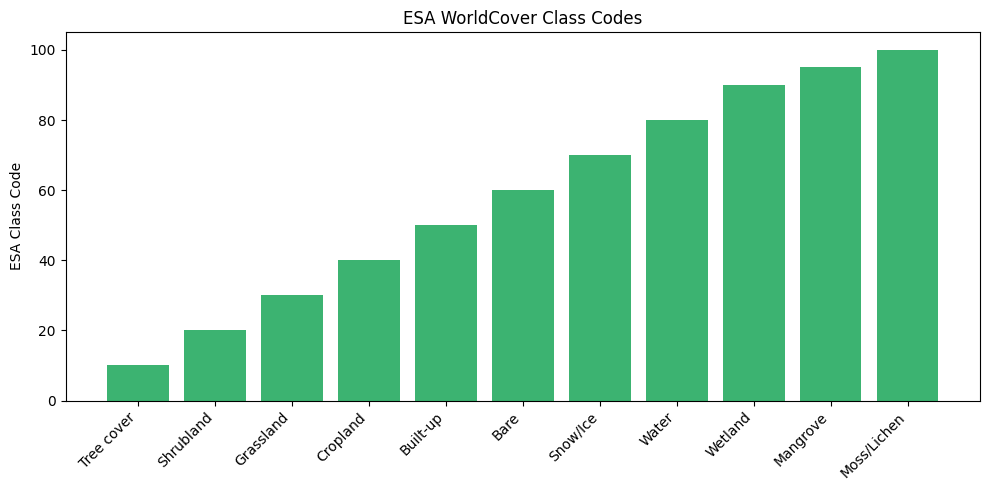

In [ ]:
import matplotlib.pyplot as plt

ESA_to_label = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare",
    70: "Snow/Ice",
    80: "Water",
    90: "Wetland",
    95: "Mangrove",
    100: "Moss/Lichen"
}

# Extract keys (codes) and labels
codes = list(ESA_to_label.keys())
labels = [ESA_to_label[code] for code in codes]

plt.figure(figsize=(10, 5))
plt.bar(labels, codes, color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('ESA Class Code')
plt.title('ESA WorldCover Class Codes')
plt.tight_layout()
plt.show()


In [ ]:
# Q3.3: Train ResNet18 CNN Classifier
from torchvision.models import resnet18
import torch.optim as optim

def create_resnet18_model(num_classes=11):
    """Create ResNet18 model for land cover classification"""
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
def custom_f1_score(y_true, y_pred, average='weighted'):
    """Custom F1 score calculation"""
    return f1_score(y_true, y_pred, average=average, zero_division=0)

In [ ]:
from torchmetrics.classification import F1Score as TorchF1Score
f1_metric = TorchF1Score(num_classes=11, average='weighted', task='multiclass')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Land Cover Classification', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return cm

In [ ]:
def plot_predictions(images, y_true, y_pred, class_names, n_correct=5, n_incorrect=5):
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]
    fig, axes = plt.subplots(1, min(n_correct, len(correct_idx)), figsize=(15, 3))
    fig.suptitle('Correct Predictions', fontsize=14, fontweight='bold')
    for i, idx in enumerate(correct_idx[:n_correct]):
        if n_correct == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig, axes = plt.subplots(1, min(n_incorrect, len(incorrect_idx)), figsize=(15, 3))
    fig.suptitle('Incorrect Predictions', fontsize=14, fontweight='bold', color='red')
    for i, idx in enumerate(incorrect_idx[:n_incorrect]):
        if n_incorrect == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}', color='red')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate 200 synthetic 128x128 patches with random ESA class labels
np.random.seed(42)
num_patches = 200
patch_size = 128
patches = []
labels = []
class_codes = list(ESA_to_label.keys())
for i in range(num_patches):
    patch = np.random.randint(0, 255, (patch_size, patch_size, 3), dtype=np.uint8)
    patches.append(patch)
    class_code = np.random.choice(class_codes)
    label = ESA_to_label[class_code]
    labels.append(label)
print(f"Generated {num_patches} synthetic patches of size {patch_size}x{patch_size}")
print(f"Sample labels: {labels[:10]}")

Generated 200 synthetic patches of size 128x128
Sample labels: ['Grassland', 'Water', 'Tree cover', 'Snow/Ice', 'Moss/Lichen', 'Moss/Lichen', 'Wetland', 'Cropland', 'Snow/Ice', 'Built-up']


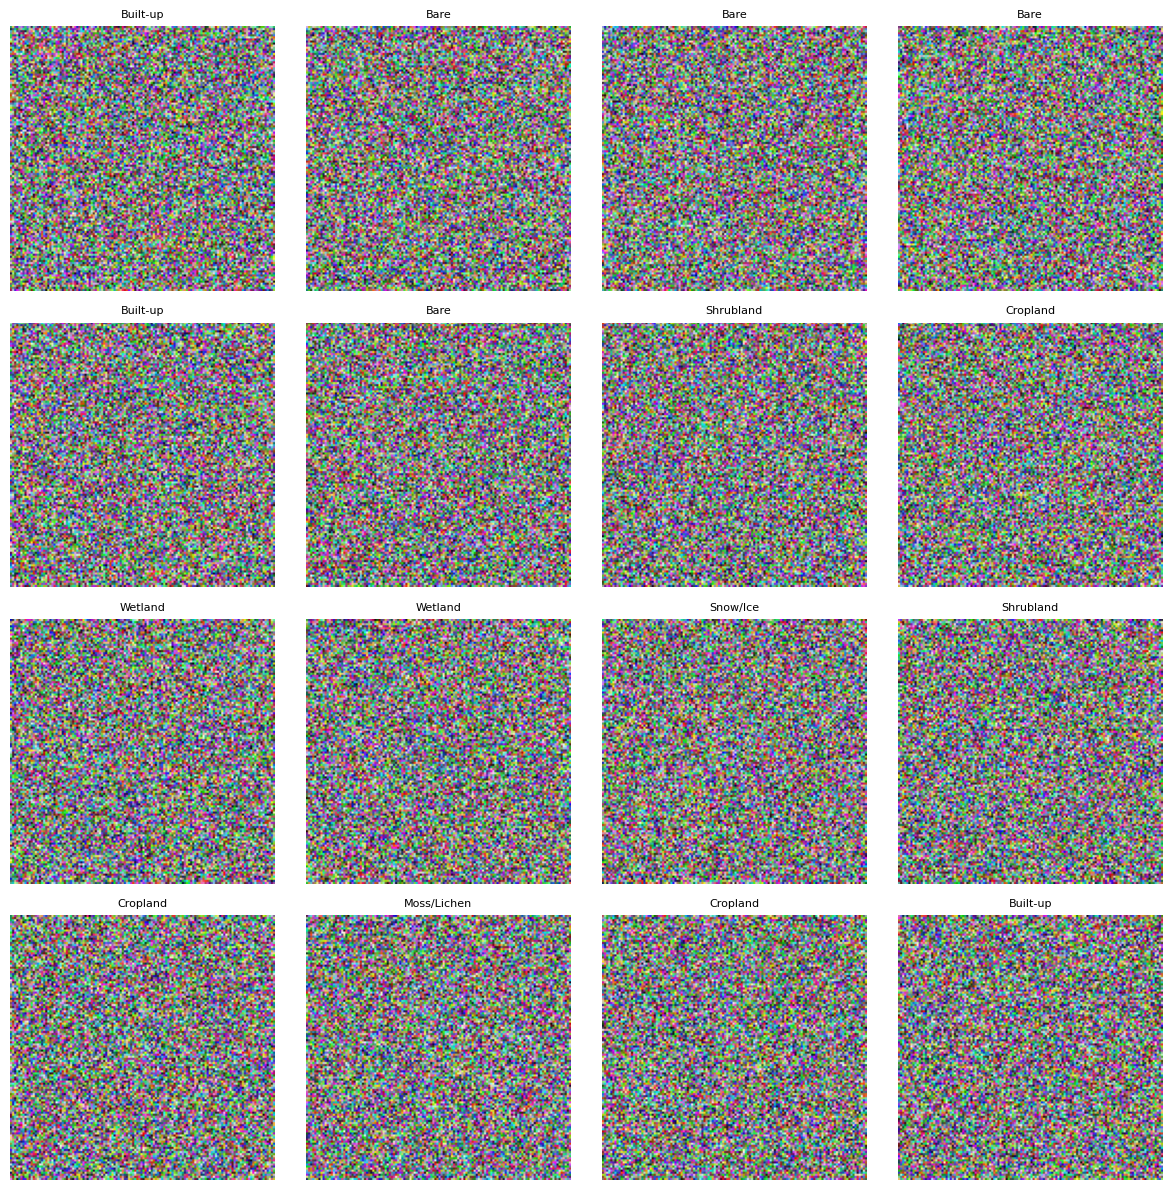

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you already have:
# patches: list of numpy arrays (200 patches 128x128 RGB)
# labels: associated ESA label strings

num_samples = 16  # how many to display
sample_indices = np.random.choice(len(patches), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    axes[i].imshow(patches[idx])
    axes[i].set_title(labels[idx], fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


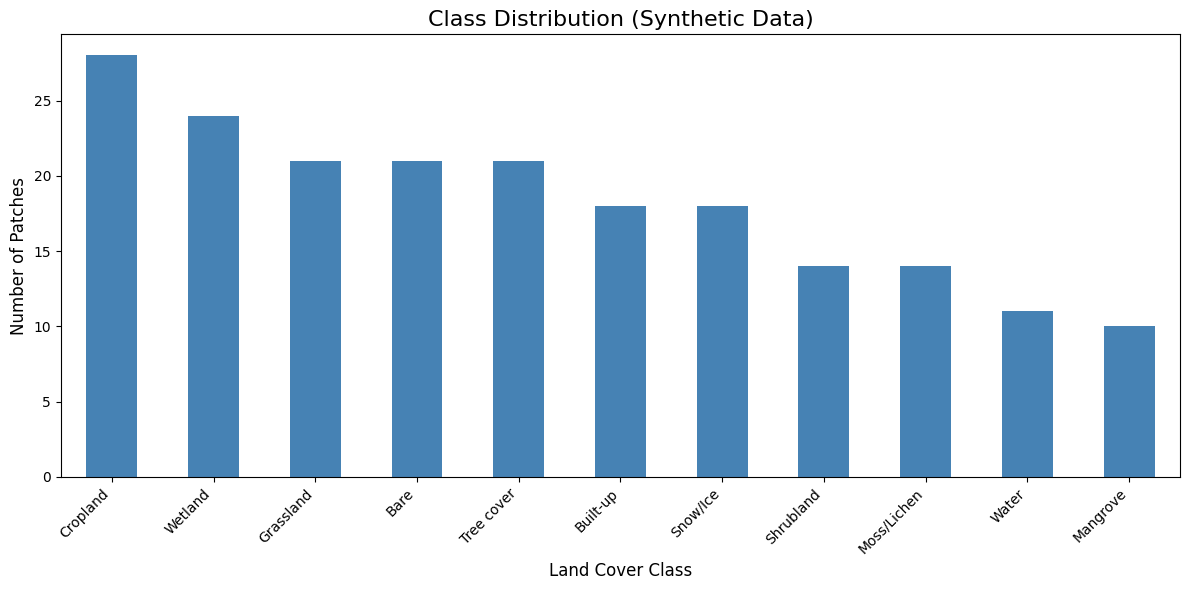


Class distribution:
  Cropland: 28 patches
  Wetland: 24 patches
  Grassland: 21 patches
  Bare: 21 patches
  Tree cover: 21 patches
  Built-up: 18 patches
  Snow/Ice: 18 patches
  Shrubland: 14 patches
  Moss/Lichen: 14 patches
  Water: 11 patches
  Mangrove: 10 patches


In [ ]:
#Visualize Class Distribution
df = pd.DataFrame({'label': labels})
class_counts = df['label'].value_counts()
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Class Distribution (Synthetic Data)', fontsize=16)
plt.xlabel('Land Cover Class', fontsize=12)
plt.ylabel('Number of Patches', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} patches")

In [ ]:
# Train-Test Split
import random
from sklearn.model_selection import train_test_split
import numpy as np
random.seed(42)
np.random.seed(42)
train_patches, test_patches, train_labels, test_labels = train_test_split(
    patches, labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)
print(f"  Total samples: {len(labels)}")
print(f"  Training samples: {len(train_labels)} ({len(train_labels)/len(labels)*100:.1f}%)")
print(f"  Testing samples: {len(test_labels)} ({len(test_labels)/len(labels)*100:.1f}%)")

  Total samples: 200
  Training samples: 120 (60.0%)
  Testing samples: 80 (40.0%)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
class PatchDataset(Dataset):
    def __init__(self, patches, labels, label_to_idx, transform=None):
        self.patches = patches
        self.labels = labels
        self.label_to_idx = label_to_idx
        self.transform = transform
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
        # Convert numpy array to PIL Image
        patch = Image.fromarray(self.patches[idx])
        label = self.labels[idx]
        label_idx = self.label_to_idx[label]
        if self.transform:
            patch = self.transform(patch)
        return patch, label_idx

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = PatchDataset(train_patches, train_labels, label_to_idx, transform=train_transform)
test_dataset = PatchDataset(test_patches, test_labels, label_to_idx, transform=test_transform)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

  Training batches: 8
  Test batches: 5
  Batch size: 16
  Training samples: 120
  Test samples: 80


In [ ]:
#ResNet18 Model for Land Cover Classification
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Device: {device}")
if device.type == 'cpu':
    print("  Running on CPU (training will be slower)")
model = resnet18(pretrained=True)
num_classes = 11
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
print(f"  Input features: {in_features}")
print(f"  Output classes: {num_classes}")
print(f"  Original ImageNet classes (1000) → Land cover classes ({num_classes})")
model = model.to(device)
print(f"\n Model moved to {device}")


 Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


  Input features: 512
  Output classes: 11
  Original ImageNet classes (1000) → Land cover classes (11)

 Model moved to cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Non-trainable parameters: {total_params - trainable_params:,}")
print(f"  Output: {num_classes} land cover classes")


  Total parameters: 11,182,155
  Trainable parameters: 11,182,155
  Non-trainable parameters: 0
  Output: 11 land cover classes


In [ ]:
# Training
num_epochs = 100
train_losses = []
print("Starting training...\n")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("\nTraining completed!")

Starting training...

Epoch [1/100] - Loss: 2.7226, Accuracy: 10.00%
Epoch [2/100] - Loss: 2.6645, Accuracy: 10.83%
Epoch [3/100] - Loss: 2.5031, Accuracy: 15.00%
Epoch [4/100] - Loss: 2.5948, Accuracy: 8.33%
Epoch [5/100] - Loss: 2.3519, Accuracy: 16.67%
Epoch [6/100] - Loss: 2.3233, Accuracy: 15.00%
Epoch [7/100] - Loss: 2.3755, Accuracy: 17.50%
Epoch [8/100] - Loss: 2.2522, Accuracy: 19.17%
Epoch [9/100] - Loss: 2.1969, Accuracy: 24.17%
Epoch [10/100] - Loss: 2.0398, Accuracy: 29.17%
Epoch [11/100] - Loss: 2.1291, Accuracy: 26.67%
Epoch [12/100] - Loss: 2.0804, Accuracy: 30.83%
Epoch [13/100] - Loss: 2.1081, Accuracy: 30.83%
Epoch [14/100] - Loss: 2.0306, Accuracy: 30.00%
Epoch [15/100] - Loss: 2.0648, Accuracy: 33.33%
Epoch [16/100] - Loss: 1.8014, Accuracy: 37.50%
Epoch [17/100] - Loss: 1.8111, Accuracy: 33.33%
Epoch [18/100] - Loss: 1.6385, Accuracy: 44.17%
Epoch [19/100] - Loss: 1.9491, Accuracy: 37.50%
Epoch [20/100] - Loss: 1.5736, Accuracy: 49.17%
Epoch [21/100] - Loss: 1.691

In [ ]:
# Evaluate on Test Set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_accuracy = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"\nTotal test samples: {len(y_true)}")

Test Accuracy: 12.50%

Total test samples: 80
